# Full Example with Bernoulli Beams

In [41]:
%matplotlib inline


In [42]:
from linkeddeepdict import LinkedDeepDict


In [43]:
# units in kN and cm

Lx, Ly, Lz = 100., 15., 10.  # size of the grid
nx, ny, nz = 4, 2, 2  # desity of the grid

d = 1.2  # outer diameter of the tube
t = 0.4  # thickness of the tube

Ex = 21000.0
nu = 0.25
fy = 35.0

loads = LinkedDeepDict()

# load case 1
loads['LC1', 'position'] = [Lx, 0, 0]
loads['LC1', 'value'] = [0, 0, 2.0, 0, 0, 0]

# load case 2
loads['LC2', 'position'] = [Lx, Ly/2, 0]
loads['LC2', 'value'] = [0, 2.0, 0, 0, 0, 0]

# load case 3
loads['LC3', 'position'] = [Lx, -Ly/2, 0]
loads['LC3', 'value'] = [0, -2.0, 0, 0, 0, 0]

filename = 'bernoulli_full_example'


In [44]:
from linkeddeepdict import LinkedDeepDict
from sigmaepsilon.solid.fourier.latex import expr_to_ltx, expr_to_ltx_breqn
from sigmaepsilon.solid.fourier.symtools import inv_sym_3x3
from neumann.array import atleastnd
from time import time

import sympy as sy
from sympy import symbols, Function, diff, Matrix, MatMul, \
    integrate, Symbol, sin, cos, pi, simplify
import pylatex as pltx
from pylatex import Command, NoEscape, Tabular, NewPage
import latexdocs
from latexdocs import Document, Table, TableX, Image
from latexdocs.utils import floatformatter
from latexdocs.preamble import append_packages, append_cover, __default__packages__
from copy import copy
import matplotlib.pyplot as plt


f2s = floatformatter(sig=4)


class MyDocument(Document):

    def init_doc(self, **kwargs) -> pltx.Document:
        """
        Initializes the document. This covers appending packages
        and the preamble.

        """
        dcls = self.__class__.documentclass
        kwargs['documentclass'] = kwargs.get('documentclass', dcls)
        #self._geometry_options["includeheadfoot"] = True
        kwargs['geometry_options'] = self._geometry_options
        doc = pltx.Document(**kwargs)
        packages = copy(__default__packages__)
        doc = append_packages(doc, packages)
        doc = append_cover(doc, self._title, self._author, self._date)
        return doc


title = "Linear Analysis of Bernoulli Beams"
doc = MyDocument(title=title, author='Bence Balogh', date=False)
doc.append(NoEscape(r'\maketitle'))
doc.append(NoEscape(r'\hrulefill'))
doc.append(NoEscape(r'\tableofcontents'))

# The height of each row is set to 1.5 relative to its default height.
doc.append(NoEscape(r'\renewcommand{\arraystretch}{1.2}'))

# The space between the text and the left/right border of its
# containing cell is set to 18pt with this command. Again,
# you may use other units if needed.
doc.append(NoEscape(r'\setlength{\tabcolsep}{6pt}'))

summary = LinkedDeepDict()

doc['Summary']


MyDocument({})

In [45]:
from polymesh.space import StandardFrame, PointCloud
from polymesh.grid import gridH8 as grid
from polymesh.topo.tr import H8_to_L2
import numpy as np

gridparams = {
    'size': (Lx, Ly, Lz),
    'shape': (nx, ny, nz),
    'origo': (0, 0, 0),
    'start': 0
}

coords, topo = grid(**gridparams)
coords, topo = H8_to_L2(coords, topo)

GlobalFrame = StandardFrame(dim=3)

points = PointCloud(coords, frame=GlobalFrame).centralize()
dx = - np.array([points[:, 0].min(), 0., 0.])
points.move(dx)
coords = points.show()


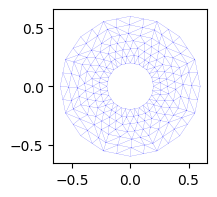

In [46]:
from sigmaepsilon.solid import BeamSection
from linkeddeepdict.tools import getallfromkwargs
from polymesh.tri.trimesh import triangulate
from polymesh.topo.tr import T6_to_T3
import matplotlib.pyplot as plt
from dewloosh.mpl import triplot

section = BeamSection('CHS', d=d, t=t, n=16)
section.calculate_section_properties()
section_props = section.section_properties
A, Ix, Iy, Iz = getallfromkwargs(['A', 'Ix', 'Iy', 'Iz'], **section_props)

G = Ex / (2 * (1 + nu))
Hooke = np.array([
    [Ex*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, Ex*Iy, 0],
    [0, 0, 0, Ex*Iz]
])

scoords, stopo = section.coords(), section.topology()
path = np.array([[0, 5, 4], [5, 1, 3], [3, 2, 4], [5, 3, 4]], dtype=int)
scoords, stopo = T6_to_T3(scoords, stopo, path=path)
triobj = triangulate(points=scoords, triangles=stopo)[-1]
fig, ax = plt.subplots(figsize=(7, 2))
triplot(triobj, fig=fig, ax=ax, lw=0.1)

fig.savefig("cross section.pdf")
caption = "Mesh of the cross section."
img = Image("cross section.pdf", position='h!',
            width='full', caption=caption)
doc['Input'].append(img)

columns = ['E', r'$\nu$', 'A', r'$I_x$', r'$I_y$', r'$I_z$']
columns = list(map(NoEscape, columns))
values = [Ex, nu, A, Ix, Iy, Iz]
values = list(map(f2s.format, values))

table = Table('| c c | c c c c |', 'h!', caption="Section properties.",
              label="table:tbl-section")
table.add_hline()
table.add_row(columns)
table.add_hline()
table.add_hline()
table.add_row(values)
table.add_hline()
doc['Input'].append(table)


In [47]:
from pylatex import LongTable, MultiColumn, NewPage

columns = ['node', r'$x$', r'$y$', r'$z$']
columns = list(map(NoEscape, columns))

data_table = LongTable("| c | c c c |")
data_table.add_hline()
data_table.add_row(columns)
data_table.add_hline()
data_table.end_table_header()
data_table.add_hline()
data_table.add_row((MultiColumn(4, align='r',
                    data='... continued on next page'),))
data_table.end_table_footer()
data_table.add_hline()
data_table.end_table_last_footer()

for i in range(coords.shape[0]):
    row = [i + 1] + list(map(f2s.format, coords[i]))
    data_table.add_row(row)
    
doc['Input', 'Mesh'].append(data_table)

In [48]:
from pylatex import LongTable, MultiColumn, NewPage

columns = ['cell', 'nodes']
columns = list(map(NoEscape, columns))

data_table = LongTable("| c | c |")
data_table.add_hline()
data_table.add_row(columns)
data_table.add_hline()
data_table.end_table_header()
data_table.add_hline()
data_table.add_row((MultiColumn(2, align='r',
                    data='... continued on next page'),))
data_table.end_table_footer()
data_table.add_hline()
data_table.end_table_last_footer()

for i in range(topo.shape[0]):
    row = [i + 1, list(topo[i])]
    data_table.add_row(row)
    
doc['Input', 'Mesh'].append(data_table)

In [49]:
doc['Input', 'Mesh'].append(NewPage())


## Results

### Linear Solution

In [50]:
from sigmaepsilon.solid import Structure, LineMesh, PointData
from polymesh.space import StandardFrame, frames_of_lines
from polymesh.space.utils import index_of_closest_point
from sigmaepsilon.solid.fem.cells import B2 as Beam

# space
GlobalFrame = StandardFrame(dim=3)

# essential boundary conditions
ebcinds = np.where(coords[:, 0] < 1e-12)[0]
fixity = np.zeros((coords.shape[0], 6)).astype(bool)
fixity[ebcinds, :] = True

# natural boundary conditions
nLoadCase = len(loads)
nodal_loads = np.zeros((coords.shape[0], 6, nLoadCase))
for iLC, key in enumerate(loads):
    x = loads[key]['position']
    f = loads[key]['value']
    iN = index_of_closest_point(coords, np.array(x))
    loads[key]['node'] = iN
    nodal_loads[iN, :, iLC] = f

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=nodal_loads, fixity=fixity)

# celldata
frames = frames_of_lines(coords, topo)
cd = Beam(topo=topo, frames=frames)

# set up mesh and structure
mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh)


In [51]:
import chart_studio

chart_studio.tools.set_credentials_file(username='BenceBalogh', api_key='i61lL23ZknjcBTi13eKq')
chart_studio.tools.set_config_file(world_readable=True, sharing='public')

import plotly.io as pio

fig = mesh.plot(backend='plotly')
pio.write_html(fig, file='bernoulli.html', auto_open=True)

import chart_studio.plotly as py

fig_link = py.plot(fig, filename = 'bernoulli', auto_open=False)

fig

In [81]:
fig_link

'https://plotly.com/~BenceBalogh/6/'

In [52]:
from latexdocs import Image
import qrcode

qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(fig_link)
qr.make(fit=True)

img = qr.make_image(fill_color="black", back_color="white")
img.save("qrcode.png")

caption = "Read this for an online version of the geometry."
img = Image("qrcode.png", position='h!', width='100px', caption=caption)

doc['Summary'].append(img)

In [53]:
structure.linsolve(summary=True)
dt = structure.summary['linsolve']['proc']['time']
dofsol = structure.nodal_dof_solution()
dofsol.shape


(45, 6, 3)

In [54]:
from pylatex import LongTable, MultiColumn, NewPage

nodal_loads = atleastnd(nodal_loads, 3, back=True)

nodal_loads[np.where(np.abs(nodal_loads) < 1e-8)] = 0.

columns = ['node', 'case', r'$F_x$', r'$F_y$', r'$F_z$',
           r'$M_x$', r'$M_y$', r'$M_z$']
columns = list(map(NoEscape, columns))

for case, key in enumerate(loads):
    data_table = LongTable("| c c | c c c c c c |")
    data_table.add_hline()
    data_table.add_row(columns)
    data_table.add_hline()
    data_table.end_table_header()
    data_table.add_hline()
    data_table.add_row((MultiColumn(8, align='r',
                        data='... continued on next page'),))
    data_table.end_table_footer()
    data_table.add_hline()
    data_table.end_table_last_footer()

    for i in range(nodal_loads.shape[0]):
        f = nodal_loads[i, :, case]
        row = [i + 1, key] + list(map(f2s.format, f))
        data_table.add_row(row)
        
    doc['Input', 'Nodal Loads'].append(data_table)

In [55]:
columns = ['node', 'case', r'$U_x$', r'$U_y$', r'$U_z$',
           r'$\varphi_x$', r'$\varphi_y$', r'$\varphi_z$']
columns = list(map(NoEscape, columns))
rows = []
for iLC, key in enumerate(loads):
    iN = loads[key]['node']
    u = dofsol[iN, :, iLC]
    row = [iN + 1, key] + list(map(f2s.format, u))
    rows.append(row)

caption = "DOF solutions of loaded nodes for each load case."
table = Table('| c c | c c c c c c |', 'h!', caption=caption,
              label="table:tbl-dofsol")
table.add_hline()
table.add_row(columns)
table.add_hline()
table.add_hline()
table.add_rows(rows)
table.add_hline()
doc['Results', 'Nodal DOF Solution'].append(table)


### Postprocessing

#### Nodal displacements and rotations

In [56]:
from pylatex import LongTable, MultiColumn, NewPage

dofsol = structure.nodal_dof_solution(flatten=False)
dofsol = atleastnd(dofsol, 3, back=True)

columns = ['i', 'case', r'$U_x$', r'$U_y$', r'$U_z$',
           r'$\varphi_x$', r'$\varphi_y$', r'$\varphi_z$']
columns = list(map(NoEscape, columns))

for case, key in enumerate(loads):
    data_table = LongTable("| c c | c c c c c c |")
    data_table.add_hline()
    data_table.add_row(columns)
    data_table.add_hline()
    data_table.end_table_header()
    data_table.add_hline()
    data_table.add_row((MultiColumn(8, align='r',
                        data='... continued on next page'),))
    data_table.end_table_footer()
    data_table.add_hline()
    data_table.end_table_last_footer()

    for i in range(dofsol.shape[0]):
        u = dofsol[i, :, case]
        row = [i + 1, key] + list(map(f2s.format, u))
        data_table.add_row(row)
        
    doc['Results', 'Nodal DOF Solution'].append(data_table)

In [57]:
dofsol.shape

(45, 6, 3)

#### Reaction forces and moments

In [58]:
from pylatex import LongTable, MultiColumn, NewPage

reactions = structure.reaction_forces(flatten=False)
reactions = atleastnd(reactions, 3, back=True)

reactions[np.where(np.abs(reactions) < 1e-8)] = 0.

columns = ['node', 'case', r'$F_x$', r'$F_y$', r'$F_z$',
           r'$M_x$', r'$M_y$', r'$M_z$']
columns = list(map(NoEscape, columns))

for case, key in enumerate(loads):
    data_table = LongTable("| c c | c c c c c c |")
    data_table.add_hline()
    data_table.add_row(columns)
    data_table.add_hline()
    data_table.end_table_header()
    data_table.add_hline()
    data_table.add_row((MultiColumn(8, align='r',
                        data='... continued on next page'),))
    data_table.end_table_footer()
    data_table.add_hline()
    data_table.end_table_last_footer()

    for i in range(reactions.shape[0]):
        f = reactions[i, :, case]
        row = [i + 1, key] + list(map(f2s.format, f))
        data_table.add_row(row)
        
    doc['Results', 'Reaction Forces'].append(data_table)

In [59]:
reactions.shape

(45, 6, 3)

#### Internal forces, stresses and utilization for all members

In [60]:
from sigmaepsilon.solid.material.utils import HMH_3d_v

evaluation_points = [-1., 0., 1.]

# forces
forces_all = structure.internal_forces(points=evaluation_points)
forces_all = atleastnd(forces_all, 4, back=True)

# stresses
stresses_all = section.calculate_stresses(forces_all)

# utilizations
nE, nPx, nPyz, nS, nRHS = stresses_all.shape
stresses_all = np.moveaxis(stresses_all, -1, -2)
stresses_all = np.reshape(stresses_all, (nE * nPx * nPyz * nRHS, nS))
utils_all = HMH_3d_v(*[stresses_all[:, i] for i in range(6)]) / fy
utils_all = np.reshape(utils_all, (nE, nPx, nPyz, nRHS))
stresses_all = np.reshape(stresses_all, (nE, nPx, nPyz, nRHS, nS))
stresses_all = np.moveaxis(stresses_all, -1, -2)

from neumann.array import minmax

ranges = [minmax(stresses_all[:, :, :, i, :]) for i in range(6)]
ranges.append((0.0, utils_all.max()))
ranges = np.array(ranges)

In [61]:
forces_all.shape, stresses_all.shape, utils_all.shape

((96, 3, 6, 3), (96, 3, 224, 6, 3), (96, 3, 224, 3))

In [62]:
from pylatex import LongTable, MultiColumn, NewPage, MultiRow

data = atleastnd(forces_all, 4, back=True)
data[np.where(np.abs(data) < 1e-8)] = 0

columns = ['cell', 'index', 'case', r'$N$', r'$Q_y$', r'$Q_z$',
           r'$M_x$', r'$M_y$', r'$M_z$']
columns = list(map(NoEscape, columns))

for case, key in enumerate(loads):
    
    """table = Tabular("| c c c | c c c c c c |")
    table.add_hline()
    col1_cell = MultiRow(4, data='span-4')
    col2_cell = MultiRow(2, data='span-2')
    table.add_row((col1_cell, col2_cell, '3a'))
    table.add_hline(start=3)
    table.add_row(('', '', '3b'))
    table.add_hline(start=2)
    table.add_row(('', col2_cell, '3c'))
    table.add_hline(start=3)
    table.add_row(('', '', '3d'))
    table.add_hline()"""
    
    data_table = LongTable("| c c c | c c c c c c |")
    data_table.add_hline()
    data_table.add_row(columns)
    data_table.add_hline()
    data_table.end_table_header()
    data_table.add_hline()
    data_table.add_row((MultiColumn(9, align='r',
                        data='... continued on next page'),))
    data_table.end_table_footer()
    data_table.add_hline()
    data_table.end_table_last_footer()

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            f = data[i, j, :, case]
            row = [i + 1, j + 1, key] + list(map(f2s.format, f))
            data_table.add_row(row)
        
    doc['Results', 'Internal Forces'].append(data_table)

Find points with high utilizations

In [63]:
n_util = 100
iE, iPx, iPyz, iRHS = [], [], [], []
_utils_all = np.copy(utils_all)
for i in range(n_util):
    umax = _utils_all.max()
    _iE, _iPx, _iPyz, _iRHS = np.where(_utils_all == umax)
    iE.append(_iE[0])
    iPx.append(_iPx[0])
    iPyz.append(_iPyz[0])
    iRHS.append(_iRHS[0])
    _utils_all[_iE, _iPx, _iPyz, _iRHS] = 0.

In [64]:
"""util_max = utils_all.max()
util_tol = util_max * 0.7
iE, iPx, iPyz, iRHS = np.nonzero(utils_all >= util_tol)
uiE, i = np.unique(iE, return_index=True)
iE, iPx, iPyz, iRHS = iE[i], iPx[i], iPyz[i], iRHS[i]
"""

'util_max = utils_all.max()\nutil_tol = util_max * 0.7\niE, iPx, iPyz, iRHS = np.nonzero(utils_all >= util_tol)\nuiE, i = np.unique(iE, return_index=True)\niE, iPx, iPyz, iRHS = iE[i], iPx[i], iPyz[i], iRHS[i]\n'

Plot critical results

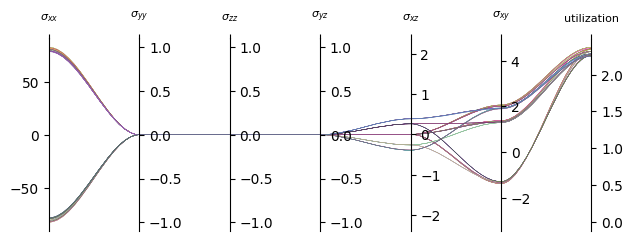

In [65]:
from neumann.array import atleast2d
from dewloosh.mpl import parallel

labels = ['$\sigma_{xx}$', '$\sigma_{yy}$', '$\sigma_{zz}$', '$\sigma_{yz}$',
          '$\sigma_{xz}$', '$\sigma_{xy}$', 'utilization']

forces_critical = forces_all[iE, iPx, :, iRHS]
stresses_critical = stresses_all[iE, iPx, iPyz, :, iRHS]
utils_critical = utils_all[iE, iPx, iPyz, iRHS]
data = np.hstack([stresses_critical, atleast2d(utils_critical, back=True)])
colors = np.random.rand(len(data), 3)

fig = parallel(data, labels=labels, padding=0.05, lw=0.2,
               colors=colors, figsize=(7, 2.5), ranges=ranges)

plt.savefig("bernoulli_B2_parallel_1.pdf")

caption = "Stress states of points with highest utilizations. The maximum value is {}."
img = Image("bernoulli_B2_parallel_1.pdf", position='h!',
            width='full', caption=caption.format(f2s.format(utils_critical.max())))

doc['Summary'].append(img)
doc['Summary'].append(NewPage())

In [66]:
utils_critical.max(), utils_all.max()

(2.369918748119055, 2.369918748119055)

Find points with highest utilizations

In [67]:
forces_critical.shape, stresses_critical.shape, utils_critical.shape

((100, 6), (100, 6), (100,))

In [68]:
i_critical = np.where(utils_critical == utils_critical.max())[0][0]
iE_critical, iPx_critical, iPyz_critical, iRHS_critical = \
    iE[i_critical], iPx[i_critical], iPyz[i_critical], iRHS[i_critical]
#forces_max = forcesi_critical[i_critical]
#stresses_max = stressesi_critical[i_critical]

txt = r"The highest utilization ${}$ occurs at element ${}$, from load case ${}$ at location $\xi={}$."
u_max = f2s.format(utils_all.max())
loc_critical = f2s.format(evaluation_points[iPx_critical])
content = NoEscape(txt.format(u_max, iE_critical, iRHS_critical, loc_critical))
doc['Summary'].append(content)

Plot results

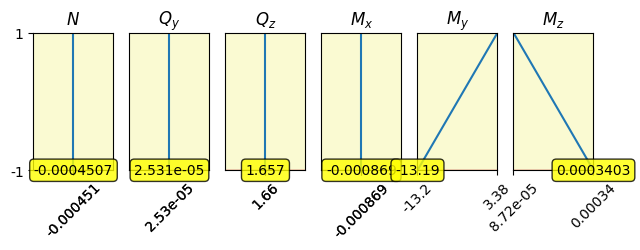

In [69]:
import matplotlib.pyplot as plt
from dewloosh.mpl import aligned_parallel

data = forces_all[iE_critical, :, :, iRHS_critical]  # (3, 6)
labels = ['$N$', '$Q_y$', '$Q_z$', '$M_x$', '$M_y$', '$M_z$']
fig = aligned_parallel(data, evaluation_points, labels=labels, slider=False,
                       xticksrotation=45, figsize=(7, 2.5), yticks=[-1, 1], 
                       y=evaluation_points[iPx_critical])
fig.subplots_adjust(left=0.1, bottom=0.3, right=0.9, top=0.85)

fig.savefig("bernoulli_B2_parallel_2.pdf")

caption = "Internal forces for element {} and load case {}.".format(iE_critical, iRHS_critical)
img = Image("bernoulli_B2_parallel_2.pdf", position='h!',
            width='full', caption=caption)

doc['Summary'].append(img)


Calculate stresses from internal forces

In [70]:
forces_critical = forces_all[iE_critical, iPx_critical, :, iRHS_critical]
section_stresses_critical = section.calculate_stresses(forces_critical)
section_stresses_critical.shape


(224, 6)

In [71]:
from sigmaepsilon.solid.material.utils import HMH_3d_v

section_utils = HMH_3d_v(*[section_stresses_critical[:, i] for i in range(6)]) / fy
section_utils.shape


(224,)

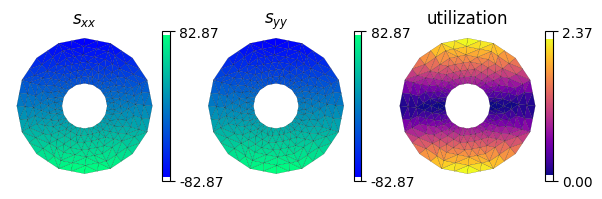

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2))
scoords, stopo = section.coords(), section.topology()
path = np.array([[0, 5, 4], [5, 1, 3], [3, 2, 4], [5, 3, 4]], dtype=int)
scoords, stopo = T6_to_T3(scoords, stopo, path=path)
triobj = triangulate(points=scoords, triangles=stopo)[-1]

ax1.set_title('$s_{xx}$')
triplot(triobj, data=section_stresses_critical[:, 0], 
        fig=fig, ax=ax1, axis='off', lw=0.1)

ax2.set_title('$s_{yy}$')
triplot(triobj, data=section_stresses_critical[:, 0], 
        fig=fig, ax=ax2, axis='off', lw=0.1)

ax3.set_title('utilization')
triplot(triobj, data=section_utils, fig=fig, ax=ax3, axis='off', 
        lw=0.1, cmap='plasma')

fig.savefig("cross section results.pdf")

caption = "Results of the cross section where the highest utilization occurs."
img = Image("cross section results.pdf", position='h!',
            width='full', caption=caption)

from pylatex import NewPage

doc['Summary'].append(img)
doc['Summary'].append(NewPage())

## Modal Analysis

In [73]:
doc['Modal Analysis']

nodal_masses = np.zeros((coords.shape[0],)) + 1
densities = np.zeros((topo.shape[0],)) + 1
mesh.pointdata['mass'] = nodal_masses
mesh.celldata['density'] = densities
freks, modes = structure.modes_of_vibration(normalize=True, as_dense=True)


In [74]:
freks.shape, modes.shape

((270,), (270, 270))

In [75]:
# check
m_eff = structure.effective_modal_masses(action=modes)
int(np.sum(np.diagonal(m_eff))) == (coords.shape[0] * 6)

False

In [76]:
nN, nD, nR = dofsol.shape
dofsol = dofsol.reshape(nN * nD, nR)

In [77]:
action_y = dofsol[:, 0]
action_z = dofsol[:, 1]
actions = np.stack([action_y, action_z], axis=1)

m_eff = structure.effective_modal_masses(action=actions)
participation_factors = structure.modal_participation_factors(action=actions)
m_eff.shape, participation_factors.shape

((270, 2), (270, 2))

In [78]:
from pylatex import LongTable, MultiColumn, NewPage

nFrek = min(len(freks), 20)

columns = ['mode', r'$\lambda$', r'$m_{eff,y}$', r'$m_{eff,z}$']
columns = list(map(NoEscape, columns))

data_table = LongTable("| c | c | c c |")
data_table.add_hline()
data_table.add_row(columns)
data_table.add_hline()
data_table.end_table_header()
data_table.add_hline()
data_table.add_row((MultiColumn(4, align='r',
                    data='... continued on next page'),))
data_table.end_table_footer()
data_table.add_hline()
data_table.end_table_last_footer()

for i in range(nFrek):
    frek = freks[i]
    my, mz = m_eff[i, 0], m_eff[i, 1]
    fy, fz = participation_factors[i, 0], participation_factors[i, 1]
    mfy = "{} ({})".format(f2s.format(my), f2s.format(fy))
    mfz = "{} ({})".format(f2s.format(mz), f2s.format(fz))
    row = [i + 1, f2s.format(frek), mfy, mfz]
    data_table.add_row(row)
    
doc['Results', 'Modes of Vibration'].append(data_table)

In [79]:
doc.build().generate_pdf(filename, compiler='pdflatex', clean_tex=False)


In [80]:
doc.build().generate_tex(filename)
